In [1]:
import os

os.environ["SEED"] = "0"
import numpy as np
import pandas as pd
from ConfigSpace import Configuration

from src.aac.AAC import AAC
from src.configuration_space.LKH import CONFIGURATION_SPACE
from src.constant import DATA_DIR, SEED, DATABASE_DIR, MAIN_DIR
from src.database import DB
from src.database.queries import *
from src.instance.Instance import Instance
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_Instance, TSP_train_test_from_index_file, TSP_from_index_file
from src.solver.Portfolio import Portfolio
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
from src.aac.SurrogateEstimator import Estimator1, SurrogateEstimator

In [2]:
# cluster_netgen
# compression
# expansion
# explosion
# grid
# cluster
# implosion
# linearprojection
# rotation
# uniform_portgen

In [3]:
instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "TEST" / "index.json"
)

In [4]:
for i, instance in enumerate(instances):
    fpath = f"test_instances_plots/{i}.png"
    instance.plot(fpath)

In [6]:
instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "CEPS_benchmark" / "index.json"
)

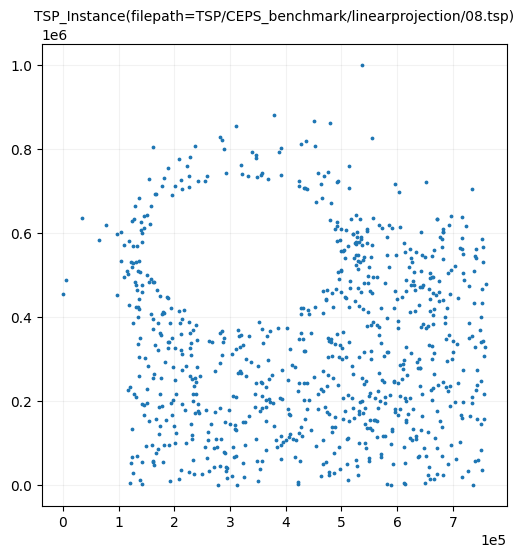

In [18]:
instances[350].plot()

In [16]:
N = 500
instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "CEPS_benchmark" / "index.json"
)

number_of_instances = N // 5
number_of_instances2 = 0
if number_of_instances > 49:
    number_of_instances2 = number_of_instances - 49
    number_of_instances = 49

train_instances = InstanceList()
test_instances = InstanceList()
for i in range(10):
    test_instances.append(instances[i * 50])
for i in range(1, 6):
    train_instances.extend(instances[i * 50 + 1 : i * 50 + number_of_instances + 1])

if number_of_instances2 > 0:
    instances = TSP_from_index_file(
        filepath=DATA_DIR / "TSP" / "MY" / "index.json"
    )
    for i in range(5):
        train_instances.extend(instances[i * 200: i * 200 + number_of_instances2])


In [18]:
for instance in train_instances:
    instance.log()

[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/01.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/02.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/03.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/04.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/05.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/06.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/07.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/08.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/09.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/10.tsp)
[2025-01-11 15:03:54] DEBUG     TSP_Inst

In [5]:
portfolio = Portfolio.from_solver_class(TSP_LKH_Solver, size=2)
portfolio

Portfolio(size=2)[Solver(id=52980316141715150), Solver(id=473831520656465062)]

In [ ]:
aac = AAC(
    portfolio=portfolio,
    instance_list=train_instances,
    prefix="config",
    max_iter=75,
    calculate_features=True,
    estimator=None,
)

last_model_iter = 0

estimator = None
db = DB()
estimator_pct = 0.5
for _ in aac.configure_iter():
    if aac.iter > 25 and aac.iter - last_model_iter >= 5:
        X, y = get_model_training_data(db)
        estimator = Estimator1(
            max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=estimator_pct
        )
        estimator.fit(X, y)
        estimator.log()
        last_model_iter = aac.iter
        aac.update(estimator=estimator)

[2025-01-10 22:05:45] DEBUG     AAC(prefix=config, iter=1, configuration_time=[inf inf])
[2025-01-10 22:05:45] DEBUG     Portfolio.evaluate(config;aac_iter=1)
[2025-01-10 22:05:45] DEBUG     Portfolio(size=2)[Solver(id=52980316141715150), Solver(id=473831520656465062)]
[2025-01-10 22:05:45] DEBUG     solve(prefix=config;aac_iter=1, solver=Solver(id=52980316141715150), instance=TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/01.tsp))
[2025-01-10 22:05:45] DEBUG     calculate_features(instance=TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/01.tsp))


In [2]:
# db = DB()
db = DB("database/run-245-sur-50-943490.db")

In [3]:
instances = pd.read_sql_query("SELECT * FROM instances", db._conn)
instances

,id,filepath,optimum,angle_min,angle_median,angle_mean,angle_max,angle_sd,angle_span,angle_coef_of_var,...,bc_no1s_min,bc_no1s_q25,bc_no1s_q50,bc_no1s_q75,bc_no1s_max,bc_p1s,bc_pn1s,bcTime,acc,acfTime
0,822075595471039179,TSP/CEPS_benchmark/cluster_netgen/01.tsp,9080004.0,0.011018,1.411569,1.481377,3.129632,0.897300,3.118615,0.605720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,411598327185181776,TSP/CEPS_benchmark/cluster_netgen/02.tsp,11020488.0,0.006047,1.536236,1.561506,3.138415,0.923695,3.132368,0.591541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,56462699908304675,TSP/CEPS_benchmark/cluster_netgen/03.tsp,9746976.0,0.005927,1.392946,1.468175,3.140087,0.912639,3.134160,0.621614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1135796868948507057,TSP/CEPS_benchmark/cluster_netgen/04.tsp,8918339.0,0.003895,1.407044,1.487371,3.135897,0.929052,3.132002,0.624627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,900769072242699328,TSP/CEPS_benchmark/cluster_netgen/05.tsp,10525131.0,0.004843,1.532593,1.541054,3.139785,0.893347,3.134942,0.579699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,1765803814609198146,TSP/CEPS_benchmark/grid/00.tsp,21258773.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,730618644385552802,TSP/CEPS_benchmark/implosion/00.tsp,20437744.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,396111139638522607,TSP/CEPS_benchmark/linearprojection/00.tsp,13972705.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,310544774750200091,TSP/CEPS_benchmark/rotation/00.tsp,16119107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
X, y = get_model_training_data(db)
X = X[:, :-50]
estimator = Estimator1(
    max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
)
estimator.fit(X, y)
estimator.log()

[2025-01-10 22:21:40] DEBUG     Estimator1(fitted=True, score=(0.73, 2.54), estimator_pct=0.5, training_data_shape=(27476, 87), non_timeout=(4136, 87))


In [25]:
pd.read_sql_query("SELECT * FROM solvers", db._conn)

,id,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,GAIN23,GAIN_CRITERION,INITIAL_STEP_SIZE,...,MAX_BREADTH,MAX_CANDIDATES,MOVE_TYPE,PATCHING_A,PATCHING_C,POPULATION_SIZE,RESTRICTED_SEARCH,SUBGRADIENT,SUBSEQUENT_MOVE_TYPE,SUBSEQUENT_PATCHING
0,52980316141715150,0.60,1.0,0.0,0.0,0.7,0.0,1.0,0.0,0.00,...,0.444643,1.000000,0.25,0.6,0.2,0.061224,0.0,0.0,5.0,1.0
1,473831520656465062,0.25,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.50,...,0.470388,0.888889,1.00,0.6,0.2,0.244898,0.0,1.0,3.0,1.0
2,1724561038518932584,0.30,0.0,1.0,2.0,0.6,0.0,1.0,1.0,0.50,...,0.192348,0.777778,0.50,0.4,0.4,0.571429,0.0,1.0,5.0,0.0
3,388564707472054326,0.65,1.0,0.0,3.0,0.8,0.0,0.0,1.0,1.00,...,0.547346,0.222222,0.50,0.8,0.0,0.377551,1.0,0.0,2.0,0.0
4,2169120517035206132,0.35,1.0,1.0,1.0,0.7,0.0,0.0,0.0,0.00,...,0.197133,0.333333,0.25,1.0,1.0,0.510204,1.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,714327894705390055,0.20,1.0,1.0,0.0,0.5,0.0,1.0,1.0,0.00,...,0.044507,0.000000,0.25,0.4,0.4,0.132653,1.0,1.0,1.0,1.0
146,419781187050281485,0.25,0.0,1.0,2.0,0.4,0.0,1.0,0.0,0.50,...,0.225689,0.555556,0.75,1.0,0.0,0.377551,0.0,0.0,5.0,1.0
147,901841810507503506,0.35,1.0,0.0,2.0,0.5,0.0,0.0,1.0,0.50,...,0.931751,0.111111,0.50,0.2,0.2,0.204082,1.0,1.0,3.0,0.0
148,1128216114050773193,0.30,0.0,1.0,3.0,0.3,0.0,1.0,0.0,0.25,...,0.241982,0.777778,0.50,0.8,1.0,0.275510,1.0,0.0,5.0,1.0


In [26]:
results = pd.read_sql_query("SELECT * FROM results", db._conn)
results

,id,prefix,solver_id,instance_id,cost,time,cached,surrogate,error
0,config;aac_iter=1_52980316141715150_8220755954...,config;aac_iter=1,52980316141715150,822075595471039179,100.00,19.340837,0,0,0
1,config;aac_iter=1_473831520656465062_822075595...,config;aac_iter=1,473831520656465062,822075595471039179,100.00,10.000000,0,0,1
2,config;aac_iter=1_52980316141715150_4115983271...,config;aac_iter=1,52980316141715150,411598327185181776,100.00,19.179252,0,0,0
3,config;aac_iter=1_473831520656465062_411598327...,config;aac_iter=1,473831520656465062,411598327185181776,100.00,10.000000,0,0,1
4,config;aac_iter=1_52980316141715150_5646269990...,config;aac_iter=1,52980316141715150,56462699908304675,100.00,18.272900,0,0,0
...,...,...,...,...,...,...,...,...,...
38745,test99_740703042325837648_310544774750200091,test99,740703042325837648,310544774750200091,2.36,2.360000,0,0,0
38746,test99_2264368277344521681_730618644385552802,test99,2264368277344521681,730618644385552802,100.00,10.000000,0,0,0
38747,test99_740703042325837648_730618644385552802,test99,740703042325837648,730618644385552802,100.00,10.000000,0,0,0
38748,test99_740703042325837648_1239352391178630764,test99,740703042325837648,1239352391178630764,3.64,3.640000,0,0,0


In [27]:
results.loc[results["prefix"].str.startswith("config"), "surrogate"].mean()

0.2523537414965986